# Sentinel-2 Image Matching - Dataset Preparation


## Installation


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import rasterio
from rasterio.plot import show
import cv2
from PIL import Image

## Configuration

In [2]:
# Dataset configuration
CONFIG = {
    # Paths
    'raw_data_dir': './data/raw',
    'pairs_dir': './data/pairs',
    'metadata_file': './data/metadata.json',
    
    # Image settings
    'target_size': (512, 512),  # Resize to this
    'bands': ['B04', 'B03', 'B02'],
    
    # Dataset
    'num_pairs': 6,         # Target number of pairs
    
    # Seasons
    'seasons': {
        'winter': ['12', '01', '02'],
        'spring': ['03', '04', '05'],
        'summer': ['06', '07', '08'],
        'autumn': ['09', '10', '11']
    }
}

# Create directories
for path in [CONFIG['raw_data_dir'], CONFIG['pairs_dir']]:
    Path(path).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    if key != 'seasons':
        print(f"  {key}: {value}")

Configuration:
  raw_data_dir: ./data/raw
  pairs_dir: ./data/pairs
  metadata_file: ./data/metadata.json
  target_size: (512, 512)
  bands: ['B04', 'B03', 'B02']
  num_pairs: 6


## Data Source Selection


In [3]:
from pathlib import Path

# Check what we have
data_dir = Path('./data/raw')
print(f"Checking data directory: {data_dir}")
print(f"Exists: {data_dir.exists()}\n")


# List all files/folders
safe_folders = list(data_dir.glob('*.SAFE'))
if safe_folders:
    print(f"\nFound {len(safe_folders)} Sentinel-2 .SAFE folders")
    for folder in safe_folders[:4]:
        print(f"  - {folder.name}")
    
# Check for image files
img_files = list(data_dir.glob('**/*.jp2')) + \
            list(data_dir.glob('**/*.tif')) + \
            list(data_dir.glob('**/*.png')) + \
            list(data_dir.glob('**/*.jpg'))
    
if img_files:
    print(f"\nFound {len(img_files)} image files")
        
    # Group by extension
    from collections import Counter
    extensions = Counter([f.suffix for f in img_files])
    for ext, count in extensions.items():
        print(f"  {ext}: {count} files")

Checking data directory: data\raw
Exists: True


Found 4 Sentinel-2 .SAFE folders
  - S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE
  - S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513.SAFE
  - S2A_MSIL1C_20190427T083601_N0207_R064_T36UYA_20190427T100851.SAFE
  - S2A_MSIL1C_20190904T083601_N0208_R064_T36UYA_20190904T110155.SAFE

Found 76 image files
  .jp2: 60 files
  .png: 12 files
  .jpg: 4 files


## Image Loading & Preprocessing

In [4]:
def load_sentinel2_rgb(image_path, bands=None):
    """
    Load Sentinel-2 image and extract RGB bands.
    
    Args:
        image_path: Path to Sentinel-2 .SAFE folder or .jp2 files
        bands: List of band names (default: ['B04', 'B03', 'B02'] for RGB)
    
    Returns:
        RGB image as numpy array (H, W, 3)
    """
    if bands is None:
        bands = ['B04', 'B03', 'B02']
    
    # Find band files
    band_files = []
    for band in bands:
        # Search for band file
        band_file = list(Path(image_path).rglob(f'*{band}*.jp2'))
        if band_file:
            band_files.append(str(band_file[0]))
    
    if len(band_files) != 3:
        raise ValueError(f"Could not find all RGB bands. Found: {len(band_files)}")
    
    # Load bands
    bands_data = []
    for band_file in band_files:
        with rasterio.open(band_file) as src:
            band = src.read(1)
            bands_data.append(band)
    
    # Stack to RGB
    rgb = np.stack(bands_data, axis=-1)
    
    return rgb

def normalize_image(img, percentile=2):
    """
    Normalize image using percentile clipping.
    
    Args:
        img: Input image
        percentile: Percentile for clipping (removes outliers)
    
    Returns:
        Normalized image in range [0, 255]
    """
    img = img.astype(np.float32)
    
    # Percentile clipping
    p_low = np.percentile(img, percentile)
    p_high = np.percentile(img, 100 - percentile)
    
    img = np.clip(img, p_low, p_high)
    
    # Normalize to [0, 255]
    img = (img - img.min()) / (img.max() - img.min()) * 255
    
    return img.astype(np.uint8)

def resize_image(img, target_size):
    """
    Resize image to target size.
    """
    return cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

def preprocess_sentinel2_image(image_path, target_size=(512, 512), min_valid_ratio=0.3):
    """
    Full preprocessing pipeline for Sentinel-2 image with NODATA handling.
    
    Args:
        image_path: Path to .SAFE folder
        target_size: Target size for resize
        min_valid_ratio: Minimum ratio of valid pixels (0-1). If less, raise error.
    
    Returns:
        Preprocessed RGB image
    
    Raises:
        ValueError: If image has too much NODATA
    """
    # Load RGB
    rgb = load_sentinel2_rgb(image_path)
    
    # Check for NODATA (black pixels)
    black_mask = (rgb[:, :, 0] < 10) & (rgb[:, :, 1] < 10) & (rgb[:, :, 2] < 10)
    valid_pixels = np.sum(~black_mask)
    total_pixels = rgb.shape[0] * rgb.shape[1]
    valid_ratio = valid_pixels / total_pixels
    
    print(f"    Valid data: {valid_ratio*100:.1f}%", end='')
    
    if valid_ratio < min_valid_ratio:
        raise ValueError(f"Too much NODATA: only {valid_ratio*100:.1f}% valid pixels")
    
    # Crop to valid region
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    # Find bounding box of valid data
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        
        # Add small margin
        margin = 10
        x = max(0, x - margin)
        y = max(0, y - margin)
        w = min(rgb.shape[1] - x, w + 2 * margin)
        h = min(rgb.shape[0] - y, h + 2 * margin)
        
        # Crop
        rgb = rgb[y:y+h, x:x+w]
        print(f" → cropped to {rgb.shape[:2]}")
    else:
        print(" → no crop needed")
    
    # Normalize
    rgb = normalize_image(rgb)
    
    # Resize
    rgb = resize_image(rgb, target_size)
    
    return rgb

## Create Image Pairs

In [5]:
def get_season(date_str):
    """
    Determine season from date string.
    
    Args:
        date_str: Date in format 'YYYYMMDD' or 'YYYY-MM-DD'
    
    Returns:
        Season name: 'winter', 'spring', 'summer', or 'autumn'
    """
    date_str = date_str.replace('-', '')
    month = date_str[4:6]
    
    for season, months in CONFIG['seasons'].items():
        if month in months:
            return season
    
    return 'unknown'

def create_image_pair(img1_path, img2_path, pair_id, output_dir):
    """
    Create and save an image pair.
    
    Args:
        img1_path: Path to first image
        img2_path: Path to second image
        pair_id: Unique pair identifier
        output_dir: Directory to save the pair
    
    Returns:
        Metadata dictionary for the pair
    """
    # Create pair directory
    pair_dir = Path(output_dir) / f"pair_{pair_id:03d}"
    pair_dir.mkdir(parents=True, exist_ok=True)
    
    # Preprocess images
    rgb1 = preprocess_sentinel2_image(img1_path, target_size=(10980, 10980))
    rgb2 = preprocess_sentinel2_image(img2_path, target_size=(10980, 10980))
    
    # Find intersection
    mask1 = (rgb1[:,:,0] > 10) | (rgb1[:,:,1] > 10) | (rgb1[:,:,2] > 10)
    mask2 = (rgb2[:,:,0] > 10) | (rgb2[:,:,1] > 10) | (rgb2[:,:,2] > 10)
    
    # Combined mask (only areas valid in both)
    combined_mask = mask1 & mask2
    
    # Find bounding box of common area
    coords = np.argwhere(combined_mask)
    if len(coords) == 0:
        raise ValueError("No common valid region!")
    
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    # Crop both images to same region
    rgb1_cropped = rgb1[y_min:y_max, x_min:x_max]
    rgb2_cropped = rgb2[y_min:y_max, x_min:x_max]
    
    # Now normalize and resize
    rgb1_norm = normalize_image(rgb1_cropped)
    rgb2_norm = normalize_image(rgb2_cropped)
    
    rgb1_final = resize_image(rgb1_norm, (512, 512))
    rgb2_final = resize_image(rgb2_norm, (512, 512))
    
    # Save images
    img1_save_path = pair_dir / "img1.png"
    img2_save_path = pair_dir / "img2.png"
    
    Image.fromarray(rgb1_final).save(img1_save_path)
    Image.fromarray(rgb2_final).save(img2_save_path)
    
    metadata = {
        'pair_id': pair_id,
        'img1': {
            'path': str(img1_save_path),
            'original_path': img1_path,
            'season': 'unknown',
            'date': 'unknown'
        },
        'img2': {
            'path': str(img2_save_path),
            'original_path': img2_path,
            'season': 'unknown',
            'date': 'unknown'
        },
        'location': 'unknown',
        'created_at': datetime.now().isoformat()
    }
    
    # Save metadata
    with open(pair_dir / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return metadata

## Visualization Function

In [6]:
def visualize_image_pair(pair_dir):
    """
    Visualize an image pair.
    """
    pair_path = Path(pair_dir)
    
    # Load images
    img1 = np.array(Image.open(pair_path / 'img1.png'))
    img2 = np.array(Image.open(pair_path / 'img2.png'))
    
    # Load metadata
    with open(pair_path / 'metadata.json', 'r') as f:
        metadata = json.load(f)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(img1)
    axes[0].set_title(f"Image 1\nSeason: {metadata['img1']['season']}")
    axes[0].axis('off')
    
    axes[1].imshow(img2)
    axes[1].set_title(f"Image 2\nSeason: {metadata['img2']['season']}")
    axes[1].axis('off')
    
    plt.suptitle(f"Pair {metadata['pair_id']}: {metadata['location']}")
    plt.tight_layout()
    plt.show()

## Process Sample Data


In [7]:
# List available images
raw_images = list(Path(CONFIG['raw_data_dir']).glob('*.SAFE'))
print(f"Found {len(raw_images)} Sentinel-2 images")

for img in raw_images[:5]:
    print(f"  - {img.name}")

Found 4 Sentinel-2 images
  - S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE
  - S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513.SAFE
  - S2A_MSIL1C_20190427T083601_N0207_R064_T36UYA_20190427T100851.SAFE
  - S2A_MSIL1C_20190904T083601_N0208_R064_T36UYA_20190904T110155.SAFE


In [8]:
from collections import defaultdict

def extract_tile_and_date(filename):
    """Extract tile ID and date from Sentinel-2 filename."""
    parts = filename.split('_')
    date = parts[2][:8]
    tile = parts[5]
    return tile, date

# Group by tile
images_by_tile = defaultdict(list)
for img_path in raw_images:
    tile, date = extract_tile_and_date(img_path.name)
    images_by_tile[tile].append((img_path, date))

print(f"Found {len(images_by_tile)} unique tiles")
for tile, images in list(images_by_tile.items())[:3]:
    print(f"  {tile}: {len(images)} images")

Found 1 unique tiles
  T36UYA: 4 images


In [9]:
all_pairs_metadata = []
pair_id = 1

for tile, images in images_by_tile.items():
    if len(images) < 2:
        continue
    
    # Sort by date
    images.sort(key=lambda x: x[1])
    
    # Create pairs from different seasons
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            img1_path, date1 = images[i]
            img2_path, date2 = images[j]
            
            season1 = get_season(date1)
            season2 = get_season(date2)
            
            # Only pair different seasons
            if season1 != season2:
                try:
                    metadata = create_image_pair(
                        str(img1_path),
                        str(img2_path),
                        pair_id,
                        CONFIG['pairs_dir']
                    )
                    
                    # Update metadata with actual info
                    metadata['img1']['season'] = season1
                    metadata['img1']['date'] = date1
                    metadata['img2']['season'] = season2
                    metadata['img2']['date'] = date2
                    metadata['location'] = tile
                    
                    pair_dir = Path(CONFIG['pairs_dir']) / f"pair_{pair_id:03d}"
                    with open(pair_dir / 'metadata.json', 'w') as f:
                        json.dump(metadata, f, indent=2)
                    
                    all_pairs_metadata.append(metadata)
                    pair_id += 1
                    
                    print(f"Created pair {pair_id - 1}: {tile} ({season1} vs {season2})")
                    
                    if pair_id > CONFIG['num_pairs']:
                        break
                except Exception as e:
                    print(f"Failed to create pair: {e}")
        
        if pair_id > CONFIG['num_pairs']:
            break

print(f"\nCreated {len(all_pairs_metadata)} pairs")

    Valid data: 100.0% → cropped to (10980, 10980)
    Valid data: 100.0% → cropped to (10980, 10980)
Created pair 1: T36UYA (winter vs summer)
    Valid data: 100.0% → cropped to (10980, 10980)
    Valid data: 100.0% → cropped to (10980, 10980)
Created pair 2: T36UYA (winter vs spring)
    Valid data: 100.0% → cropped to (10980, 10980)
    Valid data: 100.0% → cropped to (10980, 10980)
Created pair 3: T36UYA (winter vs autumn)
    Valid data: 100.0% → cropped to (10980, 10980)
    Valid data: 100.0% → cropped to (10980, 10980)
Created pair 4: T36UYA (summer vs spring)
    Valid data: 100.0% → cropped to (10980, 10980)
    Valid data: 100.0% → cropped to (10980, 10980)
Created pair 5: T36UYA (summer vs autumn)
    Valid data: 100.0% → cropped to (10980, 10980)
    Valid data: 100.0% → cropped to (10980, 10980)
Created pair 6: T36UYA (spring vs autumn)

Created 6 pairs


## Save Global Metadata

In [10]:
# Create global metadata
global_metadata = {
    'dataset_name': 'Sentinel-2 Image Matching Dataset',
    'created_at': datetime.now().isoformat(),
    'num_pairs': len(all_pairs_metadata),
    'config': CONFIG,
    'pairs': all_pairs_metadata,
    'statistics': {
        'total_images': len(all_pairs_metadata) * 2,
        'unique_locations': len(set(p['location'] for p in all_pairs_metadata)),
        'season_distribution': {}
    }
}

# Calculate season distribution
for pair in all_pairs_metadata:
    s1 = pair['img1']['season']
    s2 = pair['img2']['season']
    key = f"{s1}-{s2}"
    global_metadata['statistics']['season_distribution'][key] = \
        global_metadata['statistics']['season_distribution'].get(key, 0) + 1

# Save
with open(CONFIG['metadata_file'], 'w') as f:
    json.dump(global_metadata, f, indent=2)

print(f"Saved metadata to {CONFIG['metadata_file']}")
print(f"\nDataset Summary:")
print(f"  Total pairs: {global_metadata['num_pairs']}")
print(f"  Total images: {global_metadata['statistics']['total_images']}")
print(f"  Unique locations: {global_metadata['statistics']['unique_locations']}")
print(f"\nSeason distribution:")
for season, count in global_metadata['statistics']['season_distribution'].items():
    print(f"  {season}: {count}")

Saved metadata to ./data/metadata.json

Dataset Summary:
  Total pairs: 6
  Total images: 12
  Unique locations: 1

Season distribution:
  winter-summer: 1
  winter-spring: 1
  winter-autumn: 1
  summer-spring: 1
  summer-autumn: 1
  spring-autumn: 1


## Visualize Sample Pairs

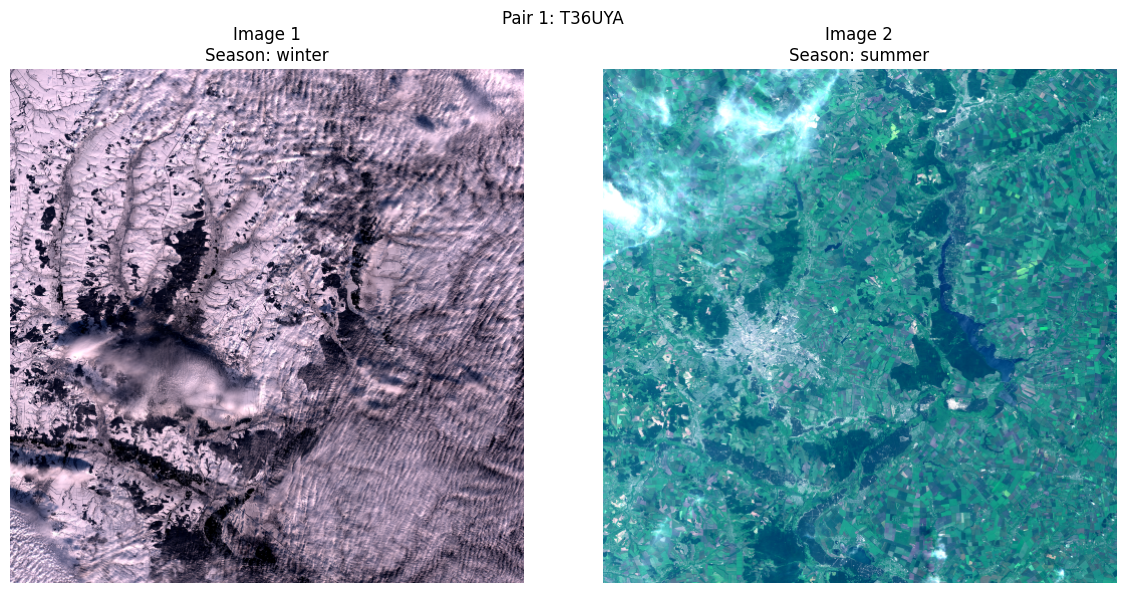

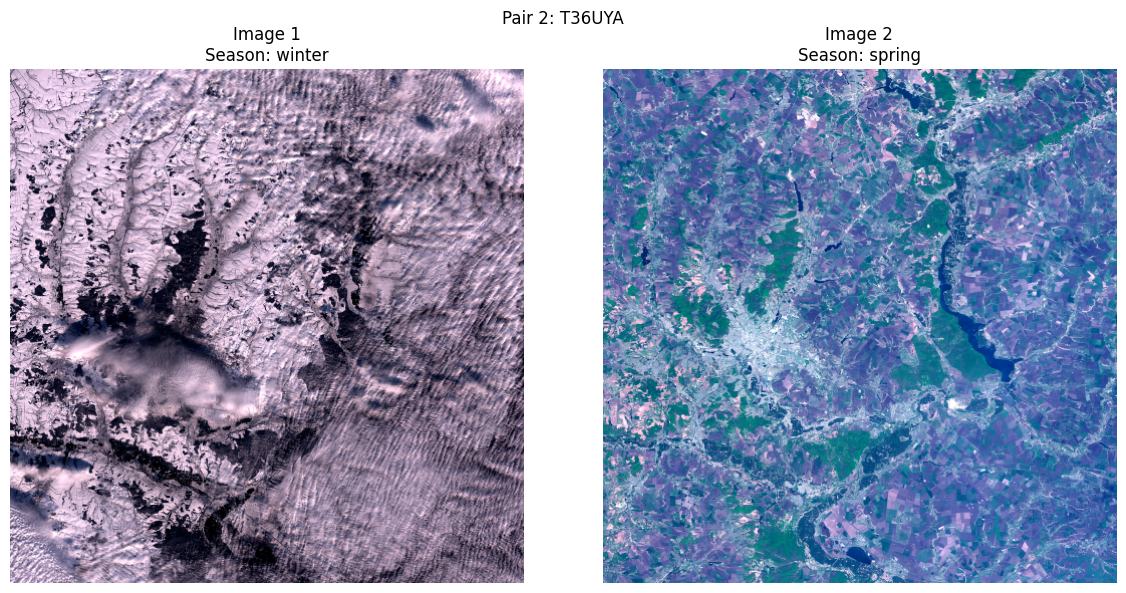

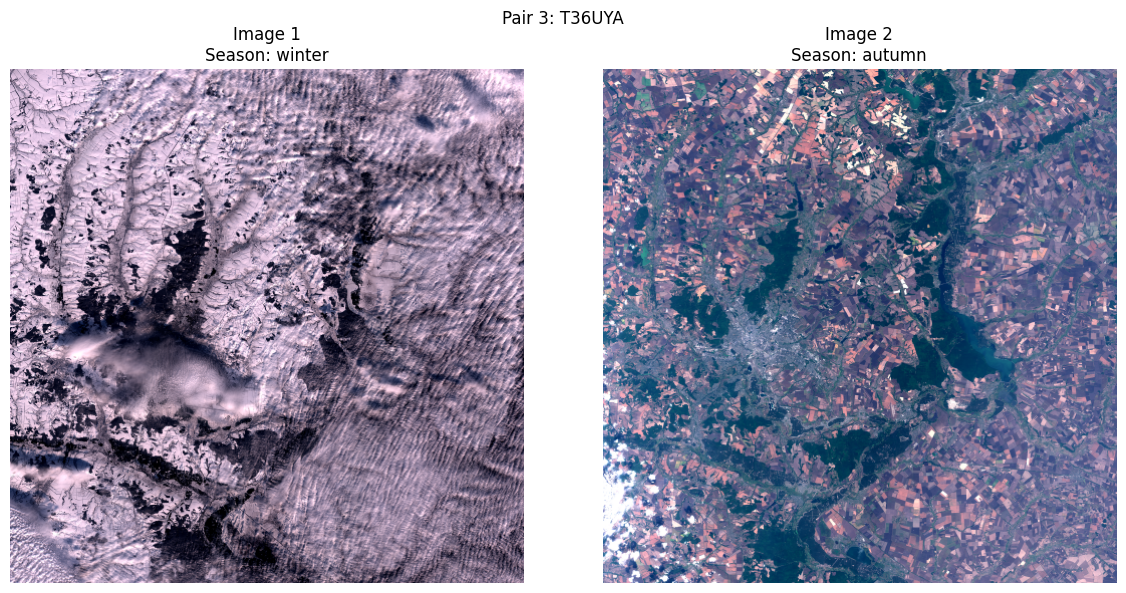

In [11]:
pair_dirs = sorted(Path(CONFIG['pairs_dir']).glob('pair_*'))[:3]

for pair_dir in pair_dirs:
    visualize_image_pair(str(pair_dir))